# Покупательская активность
Нам передали данные о покупателях интернет-магазина.

***Описание данных:*** 4 CSV-файла с данными о поведении покупателей и выручке от них. О качестве данных ничего неизвестно, так что понадобится провести их обзор и подготовку.

Описание датасетов и их столбцов:

market_file.csv содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении:
- `id` — номер покупателя в корпоративной базе данных;
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень»;
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт»;
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель;
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента;
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце;
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте;
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев;
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев;
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца;
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца;
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта;
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

market_money.csv содержит данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом:
- `id` — номер покупателя в корпоративной базе данных;
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц';
- `Выручка` — сумма выручки за период.

market_time.csv содержит данные о времени (в минутах), которое покупатель провёл на сайте в течение периода:
- `id` — номер покупателя в корпоративной базе данных;
- `Период` — название периода, во время которого зафиксировано общее время;
- `минут` — значение времени, проведённого на сайте, в минутах.

money.csv - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю:
- `id` — номер покупателя в корпоративной базе данных;
- `Прибыль` — значение прибыли.

***Цель исследования:*** Промаркировать уровень финансовой активности постоянных покупателей, собрать данные по клиентам по группам, построить модель машинного обучения, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца, выделить сегменты покупателей для разработки под них персонализированных предложений.

***Ход исследования:*** Планируется 9 этапов:
- Загрузка данных
- Предобработка данных
- Исследовательский анализ данных
- Объединение данных
- Корреляционный анализ данных
- Использование пайплайнов
- Анализ важности признаков
- Сегментация покупателей
- Общий вывод

## Загрузка данных

In [230]:
!pip install shap
!pip install phik
!pip install mkl numpy seaborn
!pip install --upgrade scikit-learn matplotlib

In [231]:
# Импортируем необходимые библиотеки и методы.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import phik

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder,
                                   StandardScaler, MinMaxScaler)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, f1_score

from phik.report import plot_correlation_matrix
from phik import report

In [232]:
# Откроем и изучим market_file.csv.
file = pd.read_csv('/datasets/market_file.csv')
file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [233]:
file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [234]:
# Откроем и изучим market_money.csv.
revenue = pd.read_csv('/datasets/market_money.csv')
revenue.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [235]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [236]:
# Откроем и изучим market_time.csv.
time = pd.read_csv('/datasets/market_time.csv')
time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [237]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [238]:
# Откроем и изучим money.csv.
profit = pd.read_csv('/datasets/money.csv', sep = ';', decimal = ',')
profit.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


In [239]:
profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Промежуточный вывод:** Видим данные о покупателях интернет-магазина. Данные соответствуют описанию задачи, но не соответствуют общему оформлению, заметны опечатки. Обзор данных методом info() не выявил пропуски и ошибки в типах данных.

## Предобработка данных

In [240]:
# Приведем названия столбцов датафреймов к общему читаемому виду.
file.columns = ['id', 'п_активность', 'тип_сервиса', 'разрешение', 'м_актив_6_мес', 'м_актив_тек_мес',
                 'длительность', 'акц_покупки', 'поп_категория', 'средний_просмотр_категорий',
                 'неоплаченные_продукты', 'ошибка_сервиса', 'среднее_количество_страниц']
time.columns = ['id', 't_период', 'время']
revenue.columns = ['id', 'r_период', 'выручка']
profit.columns = ['id', 'прибыль']

In [241]:
# Проверим датафреймы на дубликаты.
file.duplicated().sum()

0

In [242]:
time.duplicated().sum()

0

In [243]:
revenue.duplicated().sum()

0

In [244]:
profit.duplicated().sum()

0

In [245]:
# Проверим датафреймы на неявные дубликаты и опечатки.
file['п_активность'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

In [246]:
file['тип_сервиса'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

In [247]:
file['тип_сервиса'] = file['тип_сервиса'].replace('стандартт', 'стандарт')

In [248]:
file['разрешение'].unique()

array(['да', 'нет'], dtype=object)

In [249]:
file['поп_категория'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

In [250]:
revenue['r_период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [251]:
time['t_период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

In [252]:
time['t_период'] = time['t_период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

Если считать, что значения выручки записаны в рублях, то значения прибыли скорее всего записаны в тысячах рублей. Исправим это, приведя данные прибыли к тому же виду, что и выручка.

In [253]:
profit['прибыль'] = profit['прибыль'] * 1000

**Промежуточный вывод:** В ходе проверки на дубликаты явные повторы обнаружены не были. Данные приведены к одному правильному виду и готовы к работе.

## Исследовательский анализ данных

### market_file.csv

In [254]:
# Рассмотрим статистические данные датафрейма.
file.describe()

,id,м_актив_6_мес,м_актив_тек_мес,длительность,акц_покупки,средний_просмотр_категорий,неоплаченные_продукты,ошибка_сервиса,среднее_количество_страниц
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


array([[<Axes: title={'center': 'м_актив_6_мес'}>,
        <Axes: title={'center': 'м_актив_тек_мес'}>,
        <Axes: title={'center': 'длительность'}>],
       [<Axes: title={'center': 'акц_покупки'}>,
        <Axes: title={'center': 'средний_просмотр_категорий'}>,
        <Axes: title={'center': 'неоплаченные_продукты'}>],
       [<Axes: title={'center': 'ошибка_сервиса'}>,
        <Axes: title={'center': 'среднее_количество_страниц'}>, <Axes: >]],
      dtype=object)

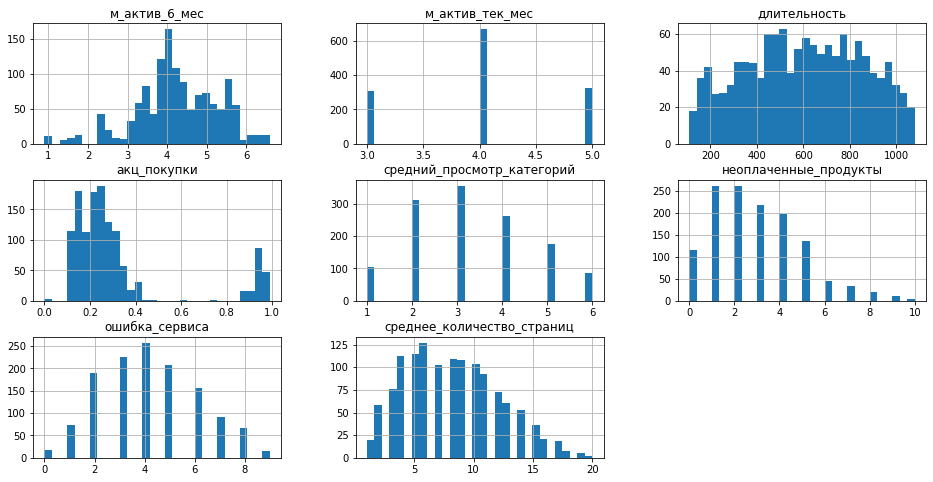

In [255]:
# Построим гистограммы для количественных признаков датафрейма.
file.drop('id', axis=1).hist(figsize=(16, 8), bins=30)

**Описание данных:** Видим распределения, не вызывающие подозрений:
- В среднем, пользователи получают 4 маркетинговых сообщения, что за текущий месяц, что за полгода.
- Среднее время с момента регистрации пользователя - примерно 600 дней.
- Выделяется две группы пользователей - те, кто заказывает товары практически несмотря на акции, и те, кто заказывает товары в основном по акции.
- Большинство пользователей просматривает 2-4 категории товаров за визит.
- У большинства пользователей в корзине находится 1-4 неоплаченных товара.
- Ошибки сервиса от 3 сбоев - не редкость среди пользователей.
- В среднем, пользователи посещают 8 страниц сайта за один визит.

In [256]:
# Проанализируем распределение категоральных признаков.
# Начнем с покупательской активности.
file['п_активность'].value_counts()

Прежний уровень    802
Снизилась          498
Name: п_активность, dtype: int64

<Axes: title={'center': 'Покупательская активность'}, ylabel='п_активность'>

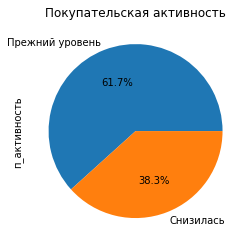

In [257]:
# Построим круговую диаграмму распределения покупательской активности.
file['п_активность'].value_counts().plot(kind='pie', title='Покупательская активность', autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении 61.7 к 38.3 с перевесом в пользу прежнего уровня покупательской активности.

In [258]:
# Рассмотрим тип сервиса.
file['тип_сервиса'].value_counts()

стандарт    924
премиум     376
Name: тип_сервиса, dtype: int64

<Axes: title={'center': 'Тип сервиса'}, ylabel='тип_сервиса'>

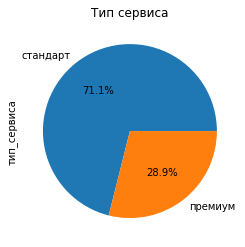

In [259]:
# Построим круговую диаграмму распределения типа сервиса.
file['тип_сервиса'].value_counts().plot(kind='pie', title='Тип сервиса', autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении 71.1 к 28.9 с перевесом в пользу стандартного типа сервиса.

In [260]:
# Рассмотрим согласие пользователя на получение дополнительных предложений о товаре.
file['разрешение'].value_counts()

да     962
нет    338
Name: разрешение, dtype: int64

<Axes: title={'center': 'Согласие пользователя на получение дополнительных предложений о товаре'}, ylabel='разрешение'>

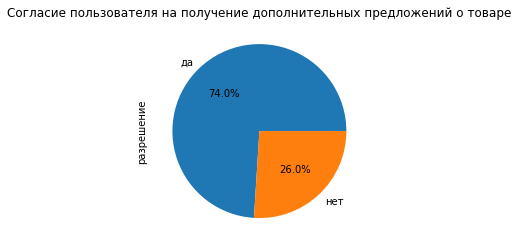

In [261]:
# Построим круговую диаграмму распределения согласия.
file['разрешение'].value_counts().plot(kind='pie',
                                       title='Согласие пользователя на получение дополнительных предложений о товаре',
                                       autopct='%1.1f%%')

**Описание данных:** Видим, что данные распределены в отношении 74 к 26 с перевесом в пользу согласия.

In [262]:
# Рассмотрим распределение самых популярных категорий товаров среди пользователей.
file['поп_категория'].value_counts()

Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: поп_категория, dtype: int64

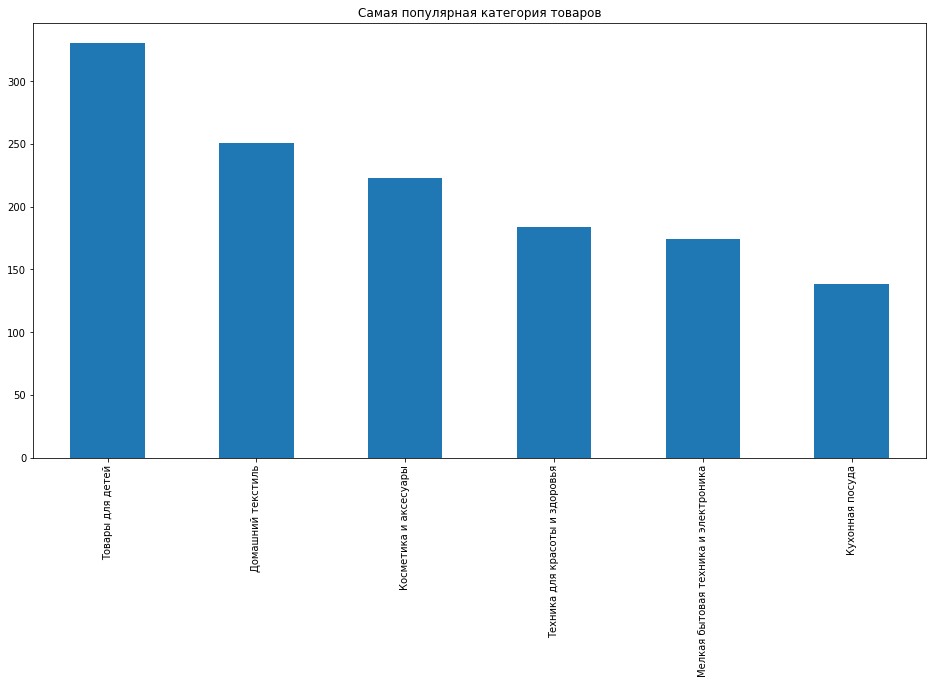

In [263]:
# Построим столбчатую диаграмму распределения самых популярных категорий.
plt.figure(figsize=(16, 8))
file['поп_категория'].value_counts().plot(kind='bar')
plt.title('Самая популярная категория товаров')
plt.show()

**Описание данных:** Видим, что самой популярной является категория "Товары для детей". Наименее популярной является "Кухонная посуда".

### market_money.csv

In [264]:
# Рассмотрим статистические данные датафрейма.
revenue.describe()

,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


<Axes: >

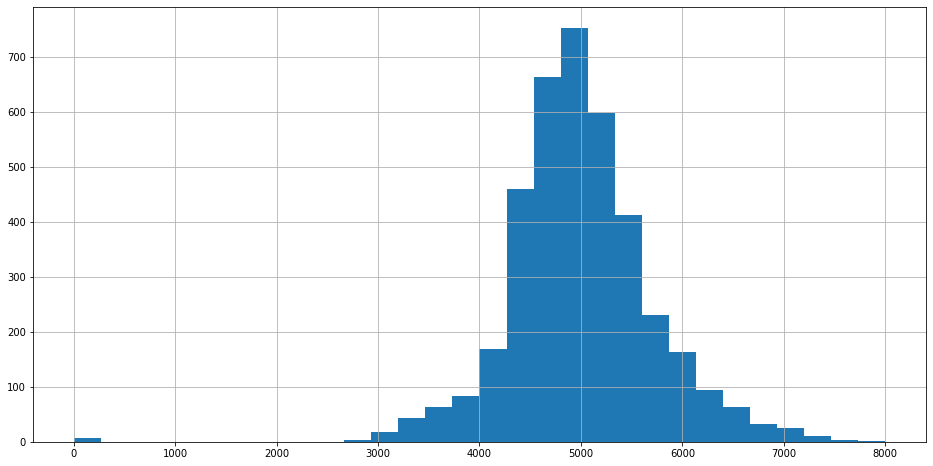

In [265]:
# Построим гистограмму для выручки.
revenue['выручка'].hist(figsize=(16, 8), bins=30, range=(0, 8000))

**Описание данных:** Видим распределение, похожее на нормальное, в диапазоне от ~ 2600 до 8000 рублей, с отдельными значениями около нуля, что не вызывает подозрений. Присутствуют выбросы за пределами 8000 рублей, которые уже вряд ли реальны. Заменим их по медиане.

In [266]:
revenue.loc[revenue['выручка'] > 8000, 'выручка'] = revenue['выручка'].median()

### market_time.csv

In [267]:
# Рассмотрим статистические данные датафрейма.
time.describe()

,id,время
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


<Axes: >

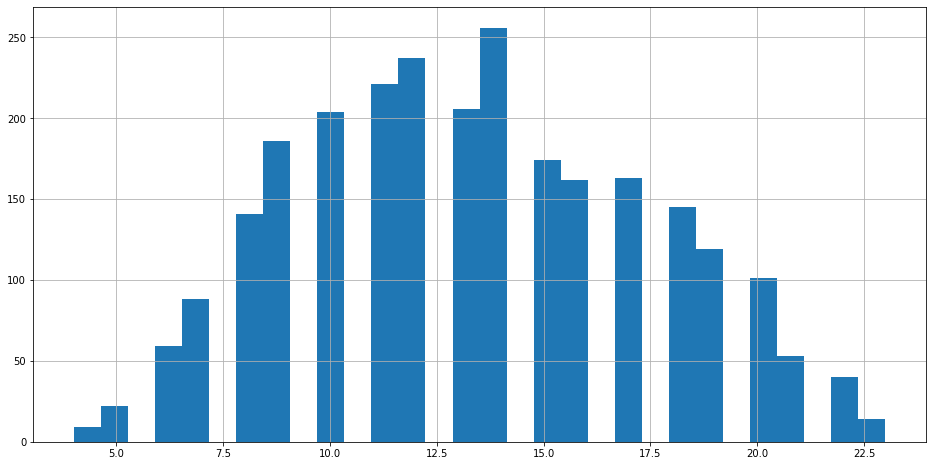

In [268]:
# Построим гистограмму для времени, проведенного пользователем на сайте.
time['время'].hist(figsize=(16, 8), bins=30)

**Описание данных:** Видим распределение, похожее на нормальное, в диапазоне от 4 до 23 минут.

### money.csv

In [269]:
# Рассмотрим статистические данные датафрейма.
profit.describe()

,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3996.630769
std,375.421985,1013.722112
min,215348.000000,860.000000
25%,215672.750000,3300.000000
50%,215997.500000,4045.000000
75%,216322.250000,4670.000000
max,216647.000000,7430.000000


<Axes: >

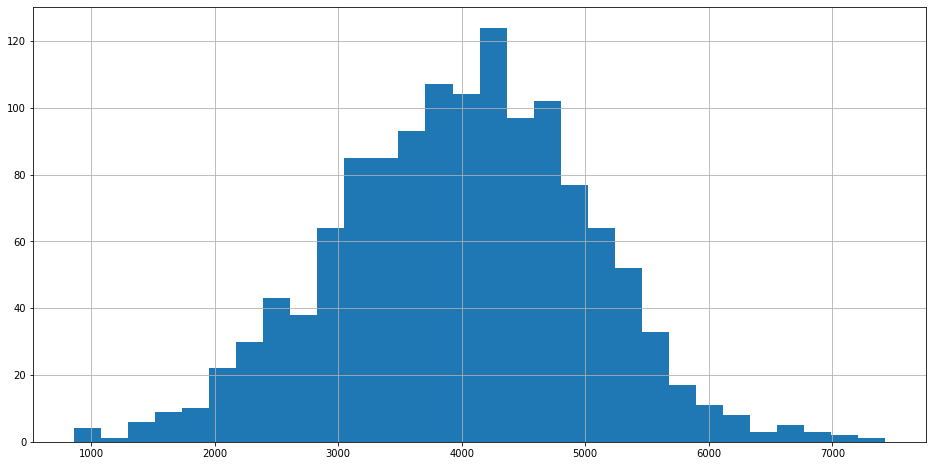

In [270]:
# Построим гистограмму для прибыли.
profit['прибыль'].hist(figsize=(16, 8), bins=30)

**Описание данных:** Видим распределение, похожее на нормальное, в диапазоне от 860 до 7430 рублей.

**Промежуточный вывод:** В целом, за исключением выбросов в выручке, данные выглядят нормально распределенными, без необычных выбросов. Исключением является признак акционные покупки - в нем распределение разбилось на две группы.

### Отбор клиентов с покупательской активностью не менее трёх месяцев

In [271]:
# Воспользуемся таблицей market_money.csv, содержащей данные за 3 месяца.
# Создадим разбитую по колонкам таблицу для периодов.
active_revenue = revenue.pivot(index='id', columns='r_период', values='выручка').reset_index()
active_revenue.columns = ['id', 'выручка_текущий_месяц', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц']
# Выведем пример и размерность новой таблицы.
display(active_revenue.head())
display(active_revenue.shape)

,id,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц
0,215348,0.0,0.0,3293.1
1,215349,5216.0,4472.0,4971.6
2,215350,5457.5,4826.0,5058.4
3,215351,6158.0,4793.0,6610.4
4,215352,5807.5,4594.0,5872.5


(1300, 4)

In [272]:
# Нас интересуют только клиенты с выручкой больше нуля в каждом из 3 месяцев.
active_revenue = active_revenue.query('выручка_текущий_месяц > 0 and выручка_предыдущий_месяц > 0 \
and выручка_препредыдущий_месяц > 0')
# Проверяем размерность.
active_revenue.shape

(1297, 4)

**Промежуточный вывод:** Отбор показал, что почти все клиенты что-либо покупали в период трёх месяцев, оставшихся исключим из выборки.

## Объединение данных

In [273]:
# Создадим разбитую по колонкам таблицу для периодов в market_time.csv перед объединением.
time_pivot = time.pivot(index='id', columns='t_период', values='время').reset_index()
time_pivot.columns = ['id', 'время_текущий_месяц', 'время_предыдущий_месяц']
time_pivot.head()

,id,время_текущий_месяц,время_предыдущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


In [274]:
# Объединим таблицы. money.csv не берем согласно условию.
df = file.merge(time_pivot, on='id', how='inner').merge(active_revenue, on='id', how='inner')
df.head()

,id,п_активность,тип_сервиса,разрешение,м_актив_6_мес,м_актив_тек_мес,длительность,акц_покупки,поп_категория,средний_просмотр_категорий,неоплаченные_продукты,ошибка_сервиса,среднее_количество_страниц,время_текущий_месяц,время_предыдущий_месяц,выручка_текущий_месяц,выручка_предыдущий_месяц,выручка_препредыдущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,12,10,5216.0,4472.0,4971.6
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,8,13,5457.5,4826.0,5058.4
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,11,13,6158.0,4793.0,6610.4
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,8,11,5807.5,4594.0,5872.5
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,10,10,4738.5,5124.0,5388.5


In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1297 non-null   int64  
 1   п_активность                 1297 non-null   object 
 2   тип_сервиса                  1297 non-null   object 
 3   разрешение                   1297 non-null   object 
 4   м_актив_6_мес                1297 non-null   float64
 5   м_актив_тек_мес              1297 non-null   int64  
 6   длительность                 1297 non-null   int64  
 7   акц_покупки                  1297 non-null   float64
 8   поп_категория                1297 non-null   object 
 9   средний_просмотр_категорий   1297 non-null   int64  
 10  неоплаченные_продукты        1297 non-null   int64  
 11  ошибка_сервиса               1297 non-null   int64  
 12  среднее_количество_страниц   1297 non-null   int64  
 13  время_текущий_меся

**Промежуточный вывод:** Данные объединены, датафрейм готов к дальнейшей работе.

## Корреляционный анализ данных

In [276]:
# Воспользуемся тепловой картой, чтобы построить таблицу коэффициентов корреляции признаков.
cdf = df.drop(columns=['id'])

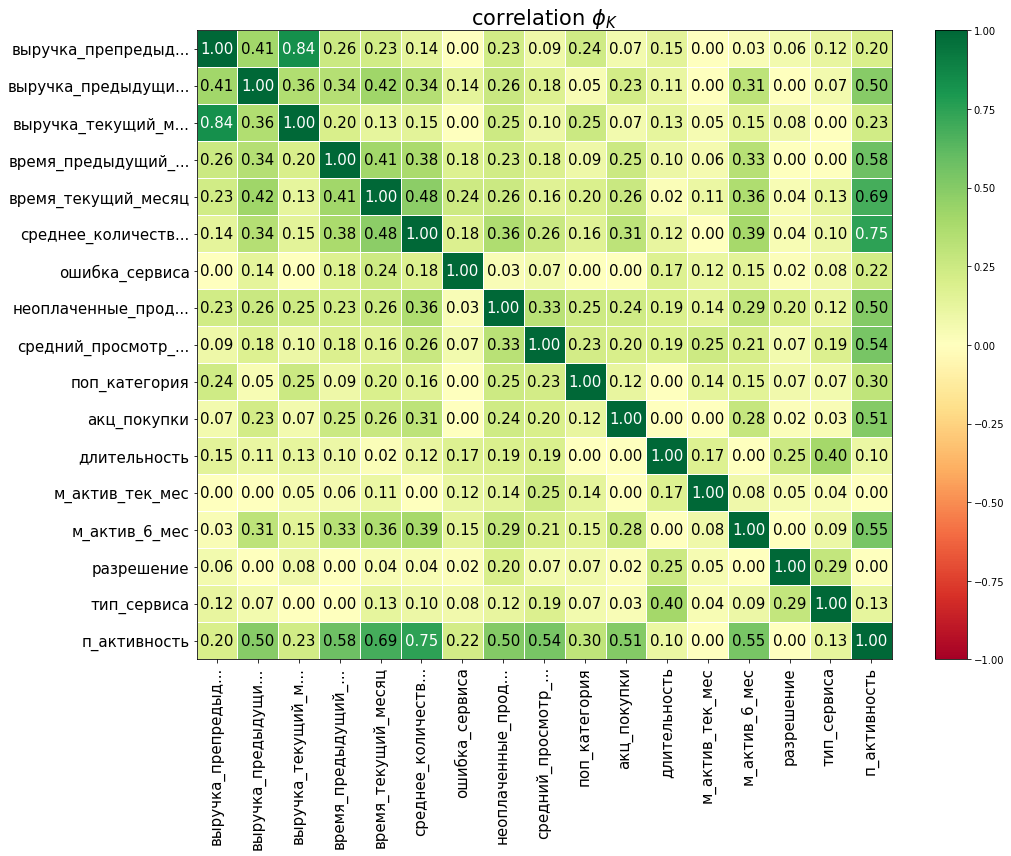

In [277]:
# список интервальных признаков
interval_cols = ['м_актив_6_мес', 'м_актив_тек_мес', 'длительность', 'акц_покупки', 'средний_просмотр_категорий',
                'неоплаченные_продукты', 'ошибка_сервиса', 'среднее_количество_страниц', 'время_текущий_месяц',
                'время_предыдущий_месяц', 'выручка_текущий_месяц', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц']

# вычисление коэффициентов корреляции phi для датафрейма df
phik_overview = cdf.phik_matrix(interval_cols=interval_cols)

# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1.5,
    figsize=(15, 12)
)

**Промежуточный вывод:** Видим мультиколлинеарность (коэффицент корреляции = 0.84) между выручкой за текущий и препредыдущий месяцы. Устраним мультиколлинеарность, удалив данные о выручке за препредыдущий месяц из тренировочной выборки в дальнейшем.

## Использование пайплайнов

In [278]:
# Преобразуем значения целевого признака.
df['п_активность'] = df['п_активность'].map({
    'Снизилась': 1,
    'Прежний уровень': 0
})
df['п_активность'] = df['п_активность'].astype('float')

df['п_активность'].value_counts()

0.0    802
1.0    495
Name: п_активность, dtype: int64

In [279]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
# Обозначим и разделим данные на выборки.
X = df.drop(['id', 'п_активность', 'выручка_препредыдущий_месяц'], axis=1)
y = df['п_активность']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE, stratify=y)

In [280]:
# Создадим списки с названиями признаков.
ohe_columns = ['поп_категория']
ord_columns = ['тип_сервиса', 'разрешение']
num_columns = ['м_актив_6_мес', 'м_актив_тек_мес', 'длительность', 'акц_покупки',
               'средний_просмотр_категорий', 'неоплаченные_продукты', 'ошибка_сервиса',
               'среднее_количество_страниц', 'время_текущий_месяц','время_предыдущий_месяц',
               'выручка_текущий_месяц', 'выручка_предыдущий_месяц']

In [281]:
# Создадим пайплайн для подготовки признаков из списка ohe_columns:
# заполнение пропусков и OHE-кодирование SimpleImputer + OHE.
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
    )

In [282]:
# Создадим пайплайн для подготовки признаков из списка ord_columns:
# заполнение пропусков и Ordinal-кодирование SimpleImputer + OE.
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['премиум', 'стандарт'],
                    ['да', 'нет']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [283]:
# Создадим пайплайн для подготовки признаков из списка num_columns:
# заполнение пропусков и minMaxScaler SimpleImputer + MinMaxScaler.
num_pipe = Pipeline(
    [('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
     ('minMaxScaler', MinMaxScaler())]
)

In [284]:
# Создадим общий пайплайн для подготовки данных.
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', num_pipe, num_columns)
    ],
    remainder='passthrough'
)

In [285]:
# Создадим итоговый пайплайн: подготовка данных и модель.
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [286]:
# Создадим param_grid.
param_grid= [
    # Словарь для модели DecisionTreeClassifier():
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range (2, 10),
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # Словарь для модели KNeighborsClassifier():
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range (3, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # Словарь для модели LogisticRegression():
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    # Словарь для модели SVC():
    {
        'models': [SVC(
            random_state=RANDOM_STATE, probability=True
        )],
        'models__C': range(1, 10),
        'models__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

В качестве метрики выберем ROC-AUC, так как она не зависит от распределения классов, в отличие от accuracy, которая может быть введена в заблуждение при несбалансированных данных, как в нашем случае.

In [287]:
# Подберем лучшую модель и ее параметры.
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['поп_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
               

In [305]:
# Посчитаем площадь ROC-кривой по вероятностям классов.
probabilities = randomized_search.best_estimator_.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Площадь ROC-кривой: 0.9250120365912374


**Промежуточный вывод:** В результате рандомизированного поиска по параметрам отобрали модель SVC (Support Vector Classifier, классификация опорных векторов) с линейным ядром и параметром C=7. Эта модель показала лучшие результаты метрики ROC-AUC на тренировочной выборке: 0.89. Площадь ROC-кривой по вероятностям классов: 0.925.

## Анализ важности признаков

In [288]:
best_pipeline = randomized_search.best_estimator_
best_model = best_pipeline.named_steps['models']
preprocessor = best_pipeline.named_steps['preprocessor']

# Получим имена признаков.
ohe = preprocessor.named_transformers_['ohe']
encoded_features = ohe.get_feature_names_out()
normal_features = X_train.drop(ohe_columns, axis=1).columns.tolist()
feature_names = np.concatenate([normal_features, encoded_features])
feature_names

array(['тип_сервиса', 'разрешение', 'м_актив_6_мес', 'м_актив_тек_мес',
       'длительность', 'акц_покупки', 'средний_просмотр_категорий',
       'неоплаченные_продукты', 'ошибка_сервиса',
       'среднее_количество_страниц', 'время_текущий_месяц',
       'время_предыдущий_месяц', 'выручка_текущий_месяц',
       'выручка_предыдущий_месяц', 'поп_категория_Косметика и аксесуары',
       'поп_категория_Кухонная посуда',
       'поп_категория_Мелкая бытовая техника и электроника',
       'поп_категория_Техника для красоты и здоровья',
       'поп_категория_Товары для детей'], dtype=object)

In [289]:
# Трансформируем данные.
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [290]:
# Используем метод SHAP.
explainer = shap.LinearExplainer(best_model, X_train_transformed)
shap_values = explainer.shap_values(X_train_transformed)

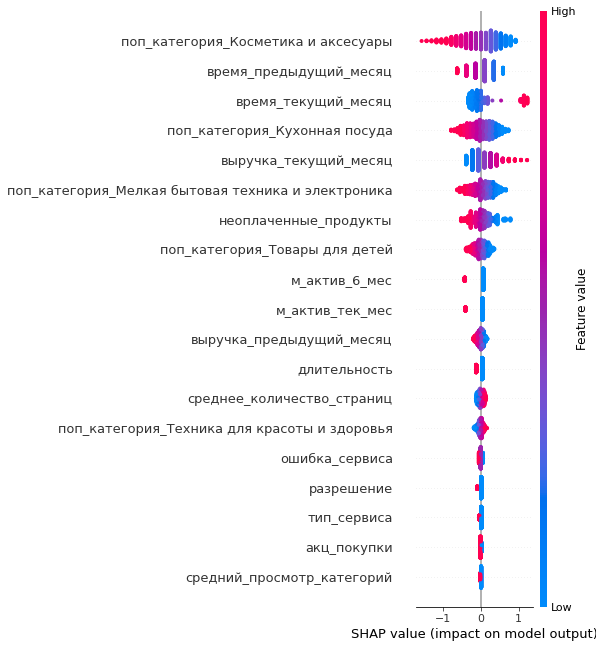

In [291]:
# Построим график.
shap.summary_plot(shap_values, X_train_transformed, feature_names=feature_names)

**Промежуточный вывод:** Согласно графику, на снижении активности пользователя сильнее всего сказывается признак времени, проведённого на сайте в текущем месяце. Скорее всего, модель регистрирует снижение количества минут, проведенных покупателем на сайте. Также на отток влияет и выручка от покупателя за текущий месяц. Среди признаков, удерживающих пользователей, сильнее всего выделяются популярные категории.

Малозначимыми признаками являются: количество дней с момента регистрации покупателя на сайте; число сбоев, которые коснулись покупателя во время посещения сайта; количество категорий, которые покупатель просмотрел за визит в течение последнего месяца; доля покупок по акции от общего числа; разрешение на рассылку дополнительных предложений о товаре и тип сервиса.

Данные, полученные с помощью графика являются ценными при моделировании и принятии бизнес-решений. Например, маркетинговые коммуникации компании имеют влияние на удержание пользователей, что значит, имеет смысл увеличить количество согласных на рассылку пользователей, например купонами в коммуникациях. Кроме того, порядок популярных категорий может подсказать, как выстраивать рекламу и акционные предложения. Если бы количество ошибок и тип сервиса сильнее влияли на отток, значит стоило бы отнестись к ним серьезнее.

## Сегментация покупателей

Выделим группу покупателей с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. С точки зрения маркетинговой стратегии эта группа выглядит довольно интересно.

In [292]:
# Воспользуемся предсказаниями нашей модели. Выделим тех пользователей,
# прибыль от которых снизится согласно предсказаниям.
predictions = best_pipeline.predict_proba(X)[:, 1]
prediction_marker = np.where(predictions > 0.5, True, False)
df_decline = df.loc[prediction_marker]

# Добавим в таблицу данные о о среднемесячной прибыли покупателей за последние 3 месяца.
df_decline = df_decline.merge(profit, on='id', how = 'left')
df_decline = df_decline.drop(columns=['п_активность'])
df_decline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426 entries, 0 to 425
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           426 non-null    int64  
 1   тип_сервиса                  426 non-null    object 
 2   разрешение                   426 non-null    object 
 3   м_актив_6_мес                426 non-null    float64
 4   м_актив_тек_мес              426 non-null    int64  
 5   длительность                 426 non-null    int64  
 6   акц_покупки                  426 non-null    float64
 7   поп_категория                426 non-null    object 
 8   средний_просмотр_категорий   426 non-null    int64  
 9   неоплаченные_продукты        426 non-null    int64  
 10  ошибка_сервиса               426 non-null    int64  
 11  среднее_количество_страниц   426 non-null    int64  
 12  время_текущий_месяц          426 non-null    int64  
 13  время_предыдущий_мес

In [293]:
# Рассмотрим долю покупок по акции для таких пользователей.
df_decline['акц_покупки'].describe()

count    426.000000
mean       0.508709
std        0.310845
min        0.110000
25%        0.270000
50%        0.350000
75%        0.930000
max        0.990000
Name: акц_покупки, dtype: float64

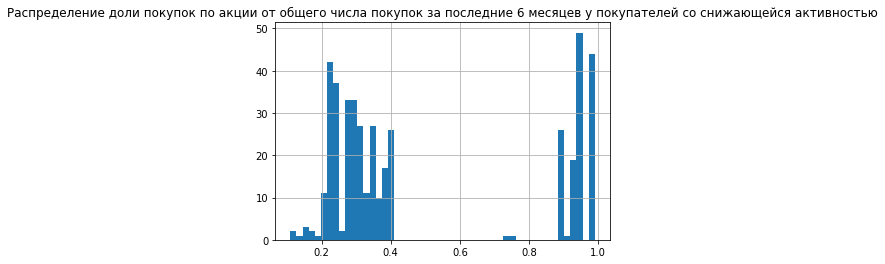

In [294]:
# Построим гистограмму.
df_decline['акц_покупки'].hist(bins=50)
plt.title("Распределение доли покупок по акции от общего числа покупок за последние 6 месяцев \
у покупателей со снижающейся активностью")
plt.show()

**Описание данных:** Как и в общих данных, выделяется две группы пользователей - те, кто заказывает товары практически несмотря на акции, и те, кто заказывает товары в основном по акции.

In [295]:
# Отберем группу пользователей, которые заказывают товары в основном по акции.
df_decline = df_decline.loc[(df_decline['акц_покупки'] > 0.8)]

In [296]:
# Проведем статистический анализ группы.
df_decline.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139 entries, 1 to 425
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           139 non-null    int64  
 1   тип_сервиса                  139 non-null    object 
 2   разрешение                   139 non-null    object 
 3   м_актив_6_мес                139 non-null    float64
 4   м_актив_тек_мес              139 non-null    int64  
 5   длительность                 139 non-null    int64  
 6   акц_покупки                  139 non-null    float64
 7   поп_категория                139 non-null    object 
 8   средний_просмотр_категорий   139 non-null    int64  
 9   неоплаченные_продукты        139 non-null    int64  
 10  ошибка_сервиса               139 non-null    int64  
 11  среднее_количество_страниц   139 non-null    int64  
 12  время_текущий_месяц          139 non-null    int64  
 13  время_предыдущий_мес

array([[<Axes: title={'center': 'м_актив_6_мес'}>,
        <Axes: title={'center': 'м_актив_тек_мес'}>,
        <Axes: title={'center': 'длительность'}>,
        <Axes: title={'center': 'акц_покупки'}>],
       [<Axes: title={'center': 'средний_просмотр_категорий'}>,
        <Axes: title={'center': 'неоплаченные_продукты'}>,
        <Axes: title={'center': 'ошибка_сервиса'}>,
        <Axes: title={'center': 'среднее_количество_страниц'}>],
       [<Axes: title={'center': 'время_текущий_месяц'}>,
        <Axes: title={'center': 'время_предыдущий_месяц'}>,
        <Axes: title={'center': 'выручка_текущий_месяц'}>,
        <Axes: title={'center': 'выручка_предыдущий_месяц'}>],
       [<Axes: title={'center': 'выручка_препредыдущий_месяц'}>,
        <Axes: title={'center': 'прибыль'}>, <Axes: >, <Axes: >]],
      dtype=object)

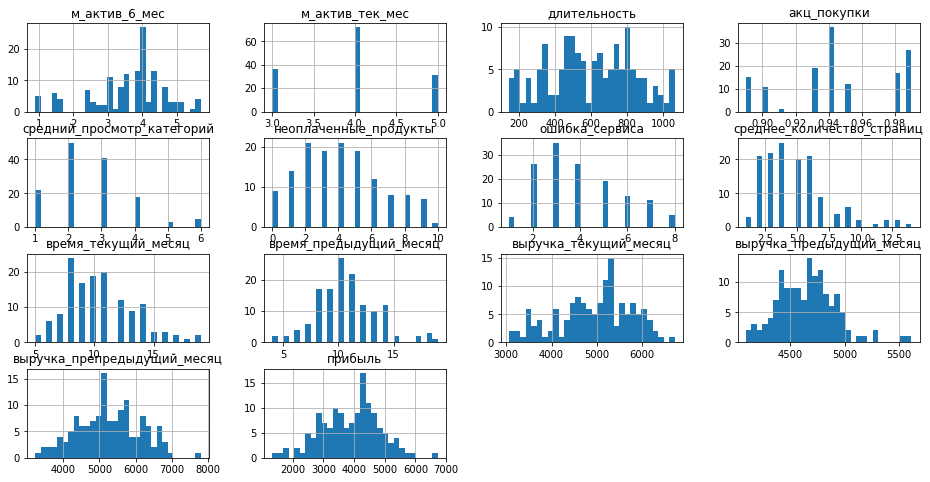

In [297]:
# Построим гистограммы для количественных признаков датафрейма.
df_decline.drop('id', axis=1).hist(figsize=(16, 8), bins=30)

**Описание данных:** Похожая на общие показатели картина, но меньше категорий за визит, неоплаченных продуктов и количества страниц за визит.

In [298]:
# Рассмотрим тип сервиса.
df_decline['тип_сервиса'].value_counts()

стандарт    91
премиум     48
Name: тип_сервиса, dtype: int64

<Axes: title={'center': 'Тип сервиса'}, ylabel='тип_сервиса'>

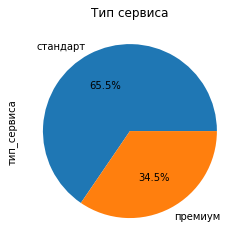

In [299]:
# Построим круговую диаграмму распределения типа сервиса.
df_decline['тип_сервиса'].value_counts().plot(kind='pie', title='Тип сервиса', autopct='%1.1f%%')

**Описание данных:** Внезапно больше премиум пользователей, чем в среднем - 34.5%.

In [300]:
# Рассмотрим распределение самых популярных категорий товаров среди пользователей.
df_decline['поп_категория'].value_counts()

Товары для детей                        46
Косметика и аксесуары                   29
Домашний текстиль                       24
Кухонная посуда                         21
Техника для красоты и здоровья          13
Мелкая бытовая техника и электроника     6
Name: поп_категория, dtype: int64

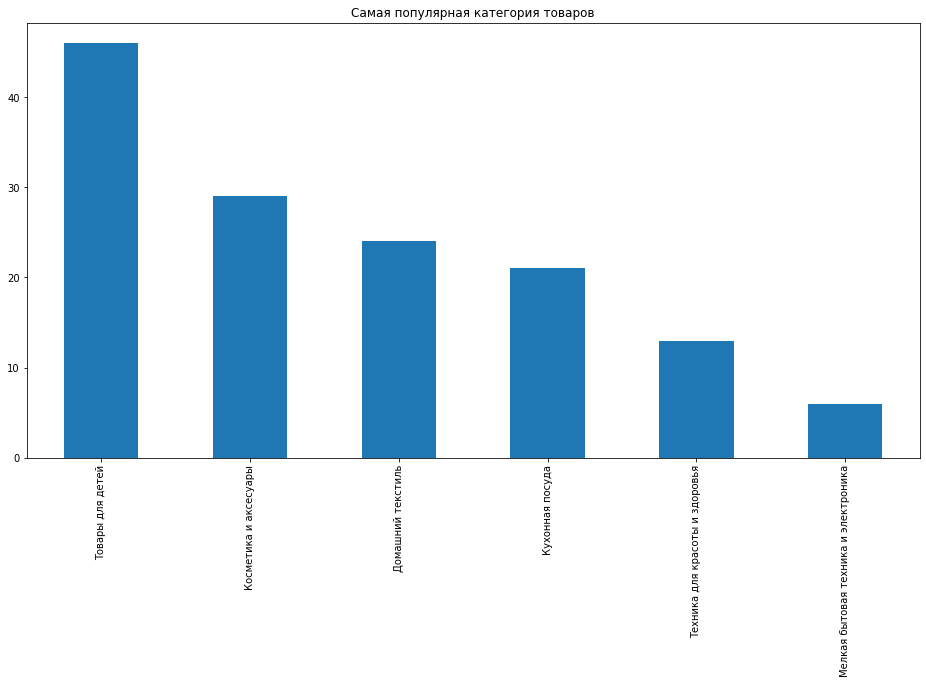

In [301]:
# Построим столбчатую диаграмму распределения самых популярных категорий.
plt.figure(figsize=(16, 8))
df_decline['поп_категория'].value_counts().plot(kind='bar')
plt.title('Самая популярная категория товаров')
plt.show()

**Описание данных:** Видим, что самой популярной является категория "Товары для детей". Наименее популярной является "Мелкая бытовая техника и электроника".

**Рекомендации для увеличения покупательской активности:**

- Увеличить число просмотренных категорий и страниц группы пользователей. Распределение активности группы на сайте ниже среднего. Скорее всего это связано с тем, что они проходятся сразу по акционным товарам. Возможно, более привлекательная реклама и баннеры разделов помогут обратить внимание на неакционные товары. 

- Персонализация рекомендаций. Возможно, стоит изучить возможность увеличения привлекательности товаров из менее популярных категорий, либо же сделать акцент на ассортименте более популярных.

- Напоминания о товарах в корзине, возможно предложение персональной скидки на отмеченный неходовой товар также может положительно сказаться на активности группы.

- Маркетинговых коммуникаций в целом немного - не больше 6. Возможно, на то есть причины, вроде излишней навязчивости или загрузки сервиса рассылок. Однако обойти это ограничение можно, создав сообщества для покупателей с обзорами, советами и живой технической поддержкой по товарам.

## Общий вывод

**Цель исследования:** Отобрали модель машинного обучения, которая промаркировала уровень финансовой активности постоянных покупателей, собрали данные по клиентам по группам, выделили один из сегментов покупателей и разработали под него персонализированные рекомендации.

**Предобработка данных:** Проверили данные на дубликаты, явные повторы обнаружены не были. Привели данные к одному правильному виду и объединили их для дальнейшей работы.

**Исследовательский анализ данных:** Провели статистический анализ всех признаков датафреймов, построили графики для каждого признака. Обнаружили выбросы в данных выручки, заменили их по медиане. За этим исключением, данные выглядят нормально распределенными, без необычных выбросов. Также провели отбор клиентов с покупательской активностью не менее трёх месяцев.

**Корреляционный анализ данных:** Провели корреляционный анализ данных. На тепловой карте корреляции Phik увидели мультиколлинеарность (коэффицент корреляции = 0.84) между выручкой за текущий и препредыдущий месяцы. Устранили мультиколлинеарность, удалив данные о выручке за препредыдущий месяц из тренировочной выборки в дальнейшем.

**Использование пайплайнов:** В качестве целевого признака взяли покупательскую активность пользователей, на остальных входных признаках, кроме данных о выручке за препредыдущий месяц, с помощью пайплайнов определили лучшую модель машинного обучения - SVC (Support Vector Classifier, классификация опорных векторов) с линейным ядром и параметром C=7. Эта модель показала лучшие результаты метрики ROC-AUC на тренировочной выборке: 0.89. Метрику ROC-AUC выбрали, так как она не зависит от распределения классов, в отличие от accuracy, которая может быть введена в заблуждение при несбалансированных данных, как в нашем случае. Площадь ROC-кривой по вероятностям классов: 0.925.

**Анализ важности признаков:** Проанализировали данные, используя метод SHAP (SHapley Additive exPlanations), построили график признаков. Согласно графику, на снижении активности пользователя сильнее всего сказывается признак времени, проведённого на сайте в текущем месяце. Скорее всего, модель регистрирует снижение количества минут, проведенных покупателем на сайте. Также на отток влияет и выручка от покупателя за текущий месяц. Среди признаков, удерживающих пользователей, сильнее всего выделяются популярные категории.

Малозначимыми признаками являются: количество дней с момента регистрации покупателя на сайте; число сбоев, которые коснулись покупателя во время посещения сайта; количество категорий, которые покупатель просмотрел за визит в течение последнего месяца; доля покупок по акции от общего числа; разрешение на рассылку дополнительных предложений о товаре и тип сервиса.

Данные, полученные с помощью графика являются ценными при моделировании и принятии бизнес-решений. Например, маркетинговые коммуникации компании имеют влияние на удержание пользователей, что значит, имеет смысл увеличить количество согласных на рассылку пользователей, например купонами в коммуникациях. Кроме того, порядок популярных категорий может подсказать, как выстраивать рекламу и акционные предложения. Если бы количество ошибок и тип сервиса сильнее влияли на отток, значит стоило бы отнестись к ним серьезнее.

**Сегментация покупателей:** Выделили группу покупателей с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. Провели статистический анализ остальных признаков внутри группы. Вывели несколько рекомендаций для увеличения покупательской активности:

- Увеличить число просмотренных категорий и страниц группы пользователей. Распределение активности группы на сайте ниже среднего. Скорее всего это связано с тем, что они проходятся сразу по акционным товарам. Возможно, более привлекательная реклама и баннеры разделов помогут обратить внимание на неакционные товары. 

- Персонализация рекомендаций. Возможно, стоит изучить возможность увеличения привлекательности товаров из менее популярных категорий, либо же сделать акцент на ассортименте более популярных.

- Напоминания о товарах в корзине, возможно предложение персональной скидки на отмеченный неходовой товар также может положительно сказаться на активности группы.

- Маркетинговых коммуникаций в целом немного - не больше 6. Возможно, на то есть причины, вроде излишней навязчивости или загрузки сервиса рассылок. Однако обойти это ограничение можно, создав сообщества для покупателей с обзорами, советами и живой технической поддержкой по товарам.